#Étude perception du temps vs musique
##Lucie GILLET & Luna MARIOTTE

In [19]:
### Import des bibliothèques nécessaires et lecture du fichier Excel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Chemin vers le fichier
excel_path = "test.xlsx"

# Lecture brute sans entête
raw = pd.read_excel(excel_path, header=None)

# Aperçu des premières lignes pour vérifier le format
raw.head(25)


,0,1,2
0,Musique 1,NaN,NaN
1,Participant,Différences,Appréciation
2,1,25,OUI
3,2,75,OUI
4,3,-15,OUI
5,4,45,OUI
6,5,31,OUI
7,6,15,OUI
8,7,5,OUI
9,8,5,OUI


In [20]:
def parse_music_blocks(raw_df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforme un fichier Excel structuré par blocs :
    - ligne 'Musique X'
    - ligne d'en-têtes : Participant | Différences | Appréciation
    - lignes de données
    en un DataFrame propre (long format) avec colonnes :
    musique | participant | difference | appreciation
    """
    # On ne garde que les 3 premières colonnes (A, B, C) du fichier brut
    df = raw_df.iloc[:, :3].copy()
    df.columns = ["c1", "c2", "c3"]

    current_music = None  # Variable pour stocker le nom de la musique actuelle
    in_table = False  # Indicateur si on est dans un tableau de données
    rows = []  # Liste pour accumuler les lignes parsées

    # Boucle sur chaque ligne du DataFrame brut
    for _, r in df.iterrows():
        c1, c2, c3 = r["c1"], r["c2"], r["c3"]

        # 1) Détection du début d'un bloc : ligne contenant "musique"
        if isinstance(c1, str) and c1.strip().lower().startswith("musique"):
            current_music = c1.strip()   # Ex: "Musique 1"
            in_table = False  # On n'est plus dans un tableau
            continue  # Passe à la ligne suivante

        # 2) Détection de la ligne d'entête du tableau : commence par "participant"
        if current_music is not None and isinstance(c1, str) and c1.strip().lower() == "participant":
            in_table = True  # Maintenant on est dans le tableau
            continue  # Passe à la ligne suivante

        # 3) Lecture des lignes de données si on est dans le tableau
        if in_table:
            # Fin du tableau = ligne entièrement vide
            if pd.isna(c1) and pd.isna(c2) and pd.isna(c3):
                in_table = False  # Fin du tableau
                continue

            # Ignore les lignes incomplètes (valeurs manquantes)
            if pd.isna(c1) or pd.isna(c2) or pd.isna(c3):
                continue

            # Conversion du participant en entier
            try:
                participant = int(c1)
            except:
                continue  # Si échec, ignore la ligne

            # Conversion de la différence en float
            try:
                diff = float(c2)
            except:
                continue  # Si échec, ignore la ligne

            # Normalisation de l'appréciation : standardise en "OUI" ou "NON"
            appreciation = str(c3).strip().upper()
            if appreciation in ["YES", "OUI"]:
                appreciation = "OUI"
            elif appreciation in ["NO", "NON"]:
                appreciation = "NON"
            else:
                continue  # Si pas reconnu, ignore

            # Ajoute la ligne parsée à la liste
            rows.append({
                "musique": current_music,
                "participant": participant,
                "difference": diff,
                "appreciation": appreciation
            })

    # Crée le DataFrame final à partir des lignes accumulées
    out = pd.DataFrame(rows)

    # Tri par musique puis participant pour un ordre propre
    if not out.empty:
        out = out.sort_values(["musique", "participant"]).reset_index(drop=True)

    return out

In [21]:
# Applique la fonction de parsing pour obtenir le DataFrame propre
data = parse_music_blocks(raw)

# Affiche des informations de base sur les données parsées
print("Nb lignes:", len(data))  # Nombre total de lignes (observations)
print("Musiques détectées:", data["musique"].unique())  # Liste des musiques trouvées
print("Répartition appréciation:\n", data["appreciation"].value_counts())  # Comptage des OUI/NON

# Aperçu des 20 premières lignes
data.head(20)

Nb lignes: 64
Musiques détectées: ['Musique 1' 'Musique 2' 'Musique 3' 'Musique 4']
Répartition appréciation:
 appreciation
OUI    51
NON    13
Name: count, dtype: int64


,musique,participant,difference,appreciation
0,Musique 1,1,25.0,OUI
1,Musique 1,2,75.0,OUI
2,Musique 1,3,-15.0,OUI
3,Musique 1,4,45.0,OUI
4,Musique 1,5,31.0,OUI
5,Musique 1,6,15.0,OUI
6,Musique 1,7,5.0,OUI
7,Musique 1,8,5.0,OUI
8,Musique 1,9,30.0,OUI
9,Musique 1,10,-5.0,OUI


In [22]:
# Normalisation des erreurs par la durée des musiques (diff / durée)
# Définissez ici les durées (en secondes) pour chaque musique détectée.
# Modifiez le dictionnaire 'durations' selon vos fichiers réels.
durations = {
    'Musique 1': 75.0,
    'Musique 2': 35.0,
    'Musique 3': 80.0,
    'Musique 4': 90.0,
}
# Ajoute la durée correspondante et calcule la différence normalisée
data['duration_s'] = data['musique'].map(durations)
missing = data['duration_s'].isna().sum()
if missing > 0:
    print(f"Attention: {missing} lignes sans durée associée. Vérifiez le dictionnaire 'durations'.")
# On supprime les lignes sans durée (ou vous pouvez les compléter manuellement)
data = data.dropna(subset=['duration_s']).copy()
# Erreur normalisée (proportion de la durée)
data['diff_norm'] = data['difference'] / data['duration_s']
data.head()

,musique,participant,difference,appreciation,duration_s,diff_norm
0,Musique 1,1,25.0,OUI,75.0,0.333333
1,Musique 1,2,75.0,OUI,75.0,1.000000
2,Musique 1,3,-15.0,OUI,75.0,-0.200000
3,Musique 1,4,45.0,OUI,75.0,0.600000
4,Musique 1,5,31.0,OUI,75.0,0.413333


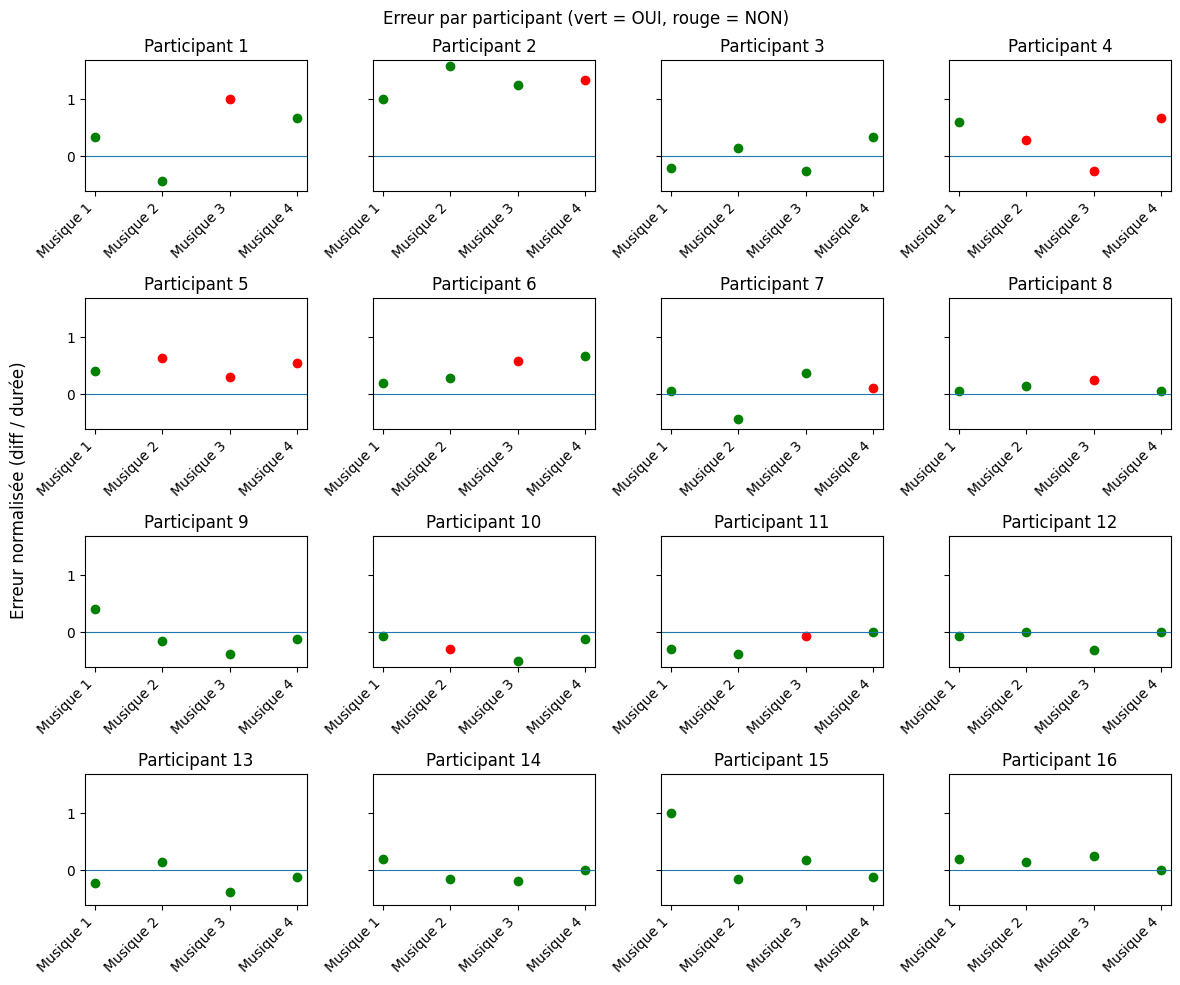

In [23]:
### Graphique des erreurs d'estimation par participant par musique

participants = sorted(data["participant"].unique())
musics = sorted(data["musique"].unique())

fig, axes = plt.subplots(4, 4, figsize=(12, 10), sharey=True)
axes = axes.flatten()

for ax, p in zip(axes, participants):
    df_p = data[data["participant"] == p]

    # x = indice de la musique (0,1,2,3)
    x = range(len(df_p))

    for i, (_, row) in enumerate(df_p.iterrows()):
        color = "green" if row["appreciation"] == "OUI" else "red" # couleur selon l'appréciation
        # Utilise l'erreur normalisée
        y = row.get("diff_norm", row.get("difference"))
        ax.scatter(i, y, color=color)

    ax.axhline(0, linewidth=0.8)
    ax.set_title(f"Participant {p}")
    ax.set_xticks(range(len(df_p)))
    ax.set_xticklabels(df_p["musique"], rotation=45, ha="right")

# Labels globaux
fig.supylabel("Erreur normalisée (diff / durée)")
fig.suptitle("Erreur par participant (vert = OUI, rouge = NON)")
plt.tight_layout()
plt.show()


In [24]:
# Calcule des statistiques par appréciation (sur diff_norm)
# Si 'diff_norm' manque (cellule non exécutée), on la calcule ici avec des durées par défaut
if 'diff_norm' not in data.columns:
    durations = {
        'Musique 1': 75.0,
        'Musique 2': 35.0,
        'Musique 3': 80.0,
        'Musique 4': 90.0,
    }
    data['duration_s'] = data['musique'].map(durations)
    missing = data['duration_s'].isna().sum()
    if missing > 0:
        print(f"Attention: {missing} lignes sans durée associée. Vérifiez le dictionnaire 'durations'.")
    data = data.dropna(subset=['duration_s']).copy()
    data['diff_norm'] = data['difference'] / data['duration_s']

summary_all = (
    data.groupby("appreciation")["diff_norm"]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
)
summary_all["sem"] = summary_all["std"] / (summary_all["n"] ** 0.5)

summary_all

,appreciation,mean,std,n,sem
0,NON,0.393864,0.469227,13,0.130140
1,OUI,0.113040,0.429673,51,0.060166


In [25]:
# Calcule un résumé statistique par musique ET par appréciation (sur diff_norm)
summary_music = (
    data.groupby(["musique", "appreciation"])["diff_norm"]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
)
summary_music["sem"] = summary_music["std"] / (summary_music["n"] ** 0.5)

summary_music.head(20)

,musique,appreciation,mean,std,n,sem
0,Musique 1,OUI,0.228333,0.388970,16,0.097243
1,Musique 2,NON,0.209524,0.461880,3,0.266667
2,Musique 2,OUI,0.059341,0.512625,13,0.142176
3,Musique 3,NON,0.304167,0.447679,6,0.182764
4,Musique 3,OUI,0.006250,0.529880,10,0.167563
5,Musique 4,NON,0.666667,0.505118,4,0.252559
6,Musique 4,OUI,0.106481,0.288635,12,0.083322


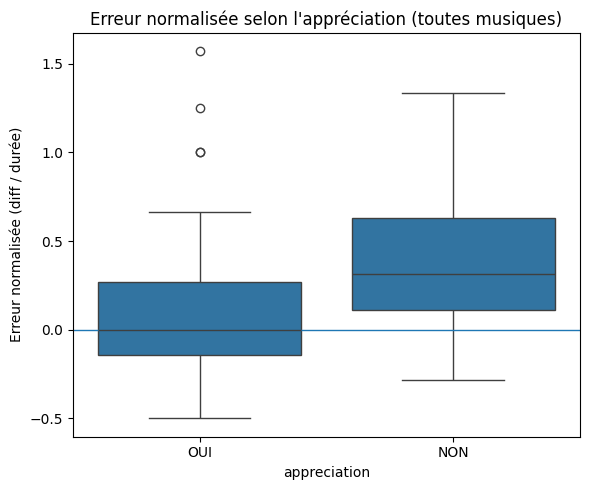

In [26]:
# Boxplot de l'erreur normalisée selon l'appréciation (toutes musiques)
plt.figure(figsize=(6,5))
sns.boxplot(x="appreciation", y="diff_norm", data=data)
plt.axhline(0, linewidth=1)
plt.ylabel("Erreur normalisée (diff / durée)")
plt.title("Erreur normalisée selon l'appréciation (toutes musiques)")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

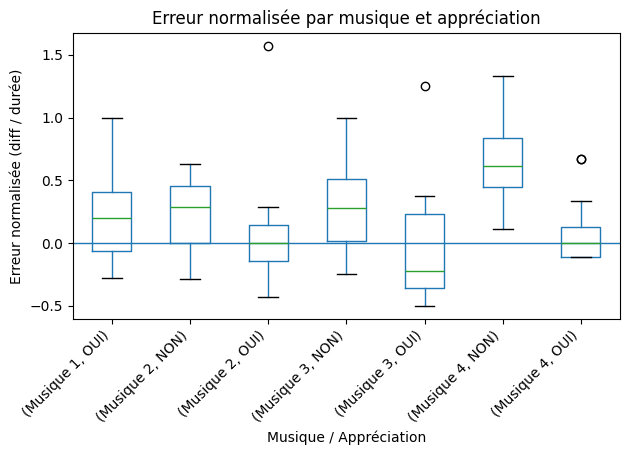

In [27]:
plt.figure(figsize=(10, 5))

data.boxplot(
    column="diff_norm",
    by=["musique", "appreciation"],
    grid=False
)

plt.axhline(0, linewidth=1)
plt.ylabel("Erreur normalisée (diff / durée)")
plt.xlabel("Musique / Appréciation")
plt.title("Erreur normalisée par musique et appréciation")
plt.suptitle("")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [29]:
# Analyses statistiques : comparaison OUI vs NON sur l'erreur normalisée (diff_norm)
import math
# ====== TEST PRINCIPAL INTRA-SUJETS (RECOMMANDÉ) ======
pp = data.groupby(["participant", "appreciation"])["diff_norm"].mean().unstack()
paired = pp.dropna()  # participants ayant OUI et NON

if len(paired) >= 3:
    # t-test apparié
    t = stats.ttest_rel(paired["OUI"], paired["NON"])
    # Wilcoxon apparié (robuste)
    w = stats.wilcoxon(paired["OUI"], paired["NON"])
    # Taille d'effet dz
    diff = paired["OUI"] - paired["NON"]
    dz = diff.mean() / diff.std(ddof=1)

    print(f"Paired N = {len(paired)}")
    print(f"t-test apparié: t={t.statistic:.3f}, p={t.pvalue:.4f}")
    print(f"Wilcoxon: W={w.statistic:.3f}, p={w.pvalue:.4f}")
    print(f"Cohen dz (OUI-NON): {dz:.3f}")
else:
    print("Pas assez de participants avec OUI et NON pour un test apparié.")

# ====== OPTION EXPLORATOIRE : PAR MUSIQUE + CORRECTION MULTI-TESTS ======
pvals = []
labels = []
for m, dfm in data.groupby("musique"):
    a = dfm[dfm.appreciation=="OUI"]["diff_norm"].values
    b = dfm[dfm.appreciation=="NON"]["diff_norm"].values
    if len(a) >= 3 and len(b) >= 3:
        # Welch (souvent ok) sinon Mann-Whitney si tu veux robuste
        stat, p = stats.ttest_ind(a, b, equal_var=False)
        pvals.append(p); labels.append(m)

# Holm-Bonferroni (simple, plus “académique”)
if len(pvals) > 0:
    order = np.argsort(pvals)
    mtests = len(pvals)
    holm = {}
    for rank, idx in enumerate(order):
        holm[labels[idx]] = min(1.0, pvals[idx] * (mtests - rank))
    print("p-values corrigées (Holm) par musique:", holm)

Paired N = 9
t-test apparié: t=-1.239, p=0.2505
Wilcoxon: W=10.000, p=0.1641
Cohen dz (OUI-NON): -0.413
p-values corrigées (Holm) par musique: {'Musique 4': np.float64(0.3269656512067312), 'Musique 3': np.float64(0.5048501051328005), 'Musique 2': np.float64(0.650861873338832)}
